<a href="https://colab.research.google.com/github/LuisRodarteSolorzano/Python-Basico-e-Intermedio/blob/main/506_GLM_Gaussiana_Poisson_Logistica.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Carga de librerías

- pandas (pd): Proporciona estructuras de datos eficientes y herramientas de manipulación de datos para el análisis y la limpieza de datos.
- seaborn (sns): Ofrece una interfaz de alto nivel para la creación de atractivas visualizaciones estadísticas en Python.
- plotly.express (px): Facilita la creación de gráficos interactivos y complejos con una sintaxis sencilla y expresiva.
- statsmodels.api (sm): Proporciona estimaciones de modelos estadísticos y pruebas para llevar a cabo análisis de regresión y otros análisis estadísticos.
- matplotlib.pyplot (plt): Es una biblioteca de bajo nivel para la creación de gráficos y visualizaciones estáticas, animadas e interactivas en Python.
- statsmodels.tools.eval_measures (smt): Ofrece herramientas para evaluar y comparar modelos estadísticos, como medidas de error y ajuste.
- numpy (np): Es fundamental para la computación científica con Python, ofreciendo poderosas estructuras de datos, implementando operaciones matemáticas y mucho más.
- sklearn.linear_model LinearRegression: proporciona una implementación eficiente y fácil de usar para realizar regresiones lineales, una técnica fundamental en el análisis de datos y el aprendizaje automático.

In [ ]:
# Required Libraries
import pandas as pd
import seaborn as sns
import plotly.express as px
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.tools.eval_measures as smt
import numpy as np
from sklearn.linear_model import LinearRegression

In [ ]:
def explorar_cuantitativas(df):
    """
    Genera histogramas y boxplots para todas las variables cuantitativas en el DataFrame.
    """
    variables_cuantitativas = df.select_dtypes(include=['float64', 'int64']).columns
    for col in variables_cuantitativas:
        fig, axs = plt.subplots(1, 2, figsize=(12, 4))

        sns.histplot(df[col], kde=True, ax=axs[0])
        axs[0].set_title(f'Histograma de {col}')

        sns.boxplot(x=df[col], ax=axs[1])
        axs[1].set_title(f'Boxplot de {col}')

        plt.tight_layout()
        plt.show()

def explorar_cualitativas(df):
    """
    Genera gráficos de barras para todas las variables cualitativas en el DataFrame.
    """
    variables_cualitativas = df.select_dtypes(include=['object', 'category']).columns
    for col in variables_cualitativas:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=df[col])
        plt.title(f'Gráfico de Barras de {col}')
        plt.xticks(rotation=45)
        plt.show()

In [ ]:
from scipy.stats import pearsonr

def explorar_relacion_con_salida(df, variable_salida):
    """
    Genera diagramas de dispersión con líneas de tendencia para cada variable cuantitativa
    en relación con la variable de salida especificada y muestra el coeficiente de correlación R.
    """
    variables_entrada = df.select_dtypes(include=['float64', 'int64']).columns
    variables_entrada = [col for col in variables_entrada if col != variable_salida]

    for col in variables_entrada:
        plt.figure(figsize=(8, 5))
        sns.regplot(x=col, y=variable_salida, data=df, line_kws={"color": "red"})

        # Calcula el coeficiente de correlación
        corr, _ = pearsonr(df[col], df[variable_salida])
        plt.title(f'Relación entre {col} y {variable_salida} - R: {corr:.2f}')

        plt.show()


In [ ]:
def explorar_relacion_cuantitativa_categorica(df, variable_cuantitativa):
    """
    Genera gráficos de barras de error (sin las barras, solo los IC) y boxplots lado a lado para
    explorar la relación entre una variable cuantitativa y cada una de las variables categóricas en el DataFrame.
    """
    variables_categoricas = df.select_dtypes(include=['object', 'category']).columns

    for col in variables_categoricas:
        fig, axs = plt.subplots(1, 2, figsize=(16, 5))

        # Gráfico de barras de error
        sns.pointplot(x=col, y=variable_cuantitativa, data=df, ci="sd", ax=axs[0])
        axs[0].set_title(f'Medias de {variable_cuantitativa} con IC por {col}')

        # Boxplot
        sns.boxplot(x=col, y=variable_cuantitativa, data=df, ax=axs[1])
        axs[1].set_title(f'Distribución de {variable_cuantitativa} por {col}')

        plt.tight_layout()
        plt.show()

In [ ]:
import statsmodels.formula.api as smf

def stepwise_selection_glm(data, response, family, threshold_in=0.01, threshold_out=0.05, verbose=False):
    included = []
    while True:
        changed = False
        # Forward step
        excluded = list(set(data.columns) - set(included) - {response})
        new_pval = pd.Series(dtype='float64', index=excluded)
        for new_column in excluded:
            formula = f"{response} ~ " + " + ".join(included + [new_column])
            model = smf.glm(formula, data=data, family=family).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed = True
            if verbose:
                print(f'Adding {best_feature}\n{model.summary()}')

        # Backward step
        if included:
            formula = f"{response} ~ " + " + ".join(included)
            model = smf.glm(formula, data=data, family=family).fit()
            pvalues = model.pvalues.iloc[1:]
            worst_pval = pvalues.max()
            if worst_pval > threshold_out:
                changed = True
                worst_feature = pvalues.idxmax()
                included.remove(worst_feature)
                if verbose:
                    print(f'Removing {worst_feature}\n{model.summary()}')

        if not changed:
            break

    return included

# Lectura de datos de mtcars

El conjunto de datos `mtcars` es un conjunto de datos clásico disponible en R y también accesible a través de `statsmodels` en Python. Originalmente proviene del conjunto de datos `Motor Trend Car Road Tests` y comprende diversos aspectos de diseño y rendimiento de 32 automóviles (modelos de 1973-74).

Veamos los detalles de las variables que contiene:

1. **mpg**: Millas por galón (eficiencia de combustible).
2. **cyl**: Número de cilindros.
3. **disp**: Desplazamiento (volumen de desplazamiento del motor, en pulgadas cúbicas).
4. **hp**: Caballos de fuerza.
5. **drat**: Relación del eje trasero.
6. **wt**: Peso (en miles de libras).
7. **qsec**: Tiempo que el vehículo tarda en recorrer 1/4 de milla (un indicador de aceleración).
8. **vs**: Tipo de motor (0 = motor en V, 1 = motor en línea).
9. **am**: Tipo de transmisión (0 = automática, 1 = manual).
10. **gear**: Número de marchas.
11. **carb**: Número de carburadores.

In [ ]:
# leer y reconfigurar la tabla de datos
mtcars = sm.datasets.get_rdataset('mtcars').data
df = mtcars[["wt", "disp", "hp", "mpg", "vs", "am"]]
df.head()

,wt,disp,hp,mpg,vs,am
rownames,,,,,,
Mazda RX4,2.620,160.0,110,21.0,0,1
Mazda RX4 Wag,2.875,160.0,110,21.0,0,1
Datsun 710,2.320,108.0,93,22.8,1,1
Hornet 4 Drive,3.215,258.0,110,21.4,1,0
Hornet Sportabout,3.440,360.0,175,18.7,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32 entries, Mazda RX4 to Volvo 142E
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wt      32 non-null     float64
 1   disp    32 non-null     float64
 2   hp      32 non-null     int64  
 3   mpg     32 non-null     float64
 4   vs      32 non-null     int64  
 5   am      32 non-null     int64  
dtypes: float64(3), int64(3)
memory usage: 2.8+ KB


In [ ]:
df["am"] = df["am"].astype('category')
df["vs"] = df["vs"].astype('category')
df.iloc[:,3] = 1/df.iloc[:,3] # estoy calculando el consumo
df.columns = ["peso", "cilindrada", "Caballos", "consumo", "vs", "am"]
    # La variable x1 es el peso
    # La variable x2 es la cilindrada
    # La variable x3 son los caballos
    # La variable y es el consumo

<ipython-input-69-1053e17fc9fb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["am"] = df["am"].astype('category')
<ipython-input-69-1053e17fc9fb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["vs"] = df["vs"].astype('category')
<ipython-input-69-1053e17fc9fb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_

In [ ]:
df.head()

,peso,cilindrada,Caballos,consumo,vs,am
rownames,,,,,,
Mazda RX4,2.620,160.0,110,0.047619,0,1
Mazda RX4 Wag,2.875,160.0,110,0.047619,0,1
Datsun 710,2.320,108.0,93,0.043860,1,1
Hornet 4 Drive,3.215,258.0,110,0.046729,1,0
Hornet Sportabout,3.440,360.0,175,0.053476,0,0


# Exploración rápida del conjunto de datos

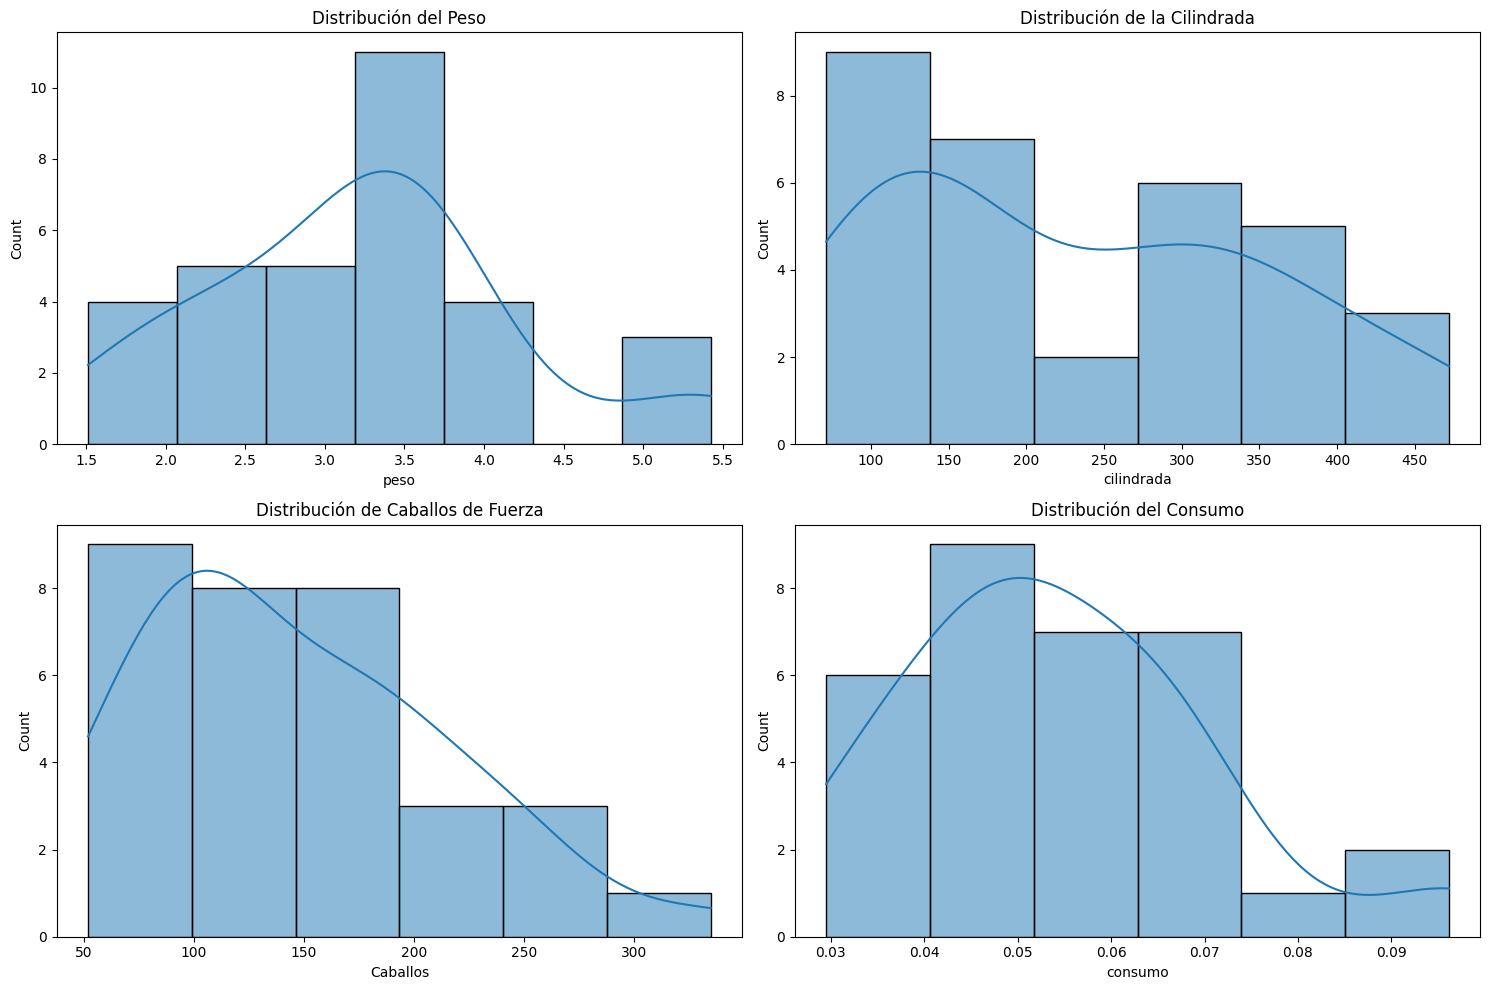

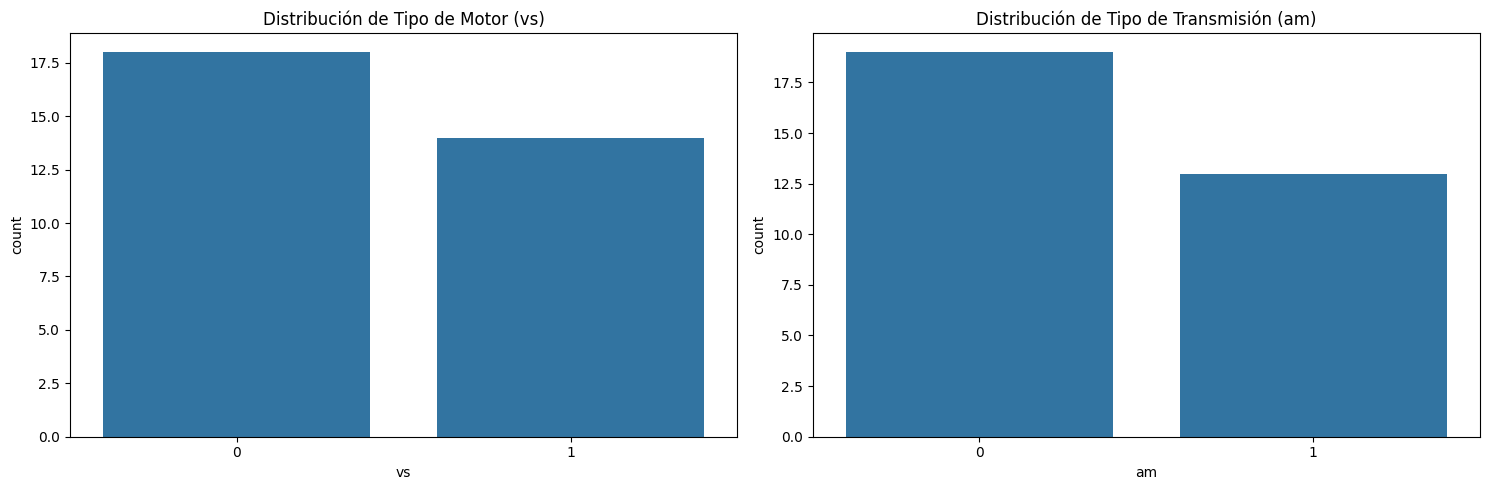

,peso,cilindrada,Caballos,consumo
count,32.000000,32.000000,32.000000,32.000000
mean,3.217250,230.721875,146.687500,0.054227
std,0.978457,123.938694,68.562868,0.016424
min,1.513000,71.100000,52.000000,0.029499
25%,2.581250,120.825000,96.500000,0.043860
50%,3.325000,196.300000,123.000000,0.052083
75%,3.610000,326.000000,180.000000,0.064834
max,5.424000,472.000000,335.000000,0.096154


In [ ]:
# Estadísticas descriptivas para las variables cuantitativas
desc_stats = df.describe()

# Gráficos para las variables cuantitativas
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
sns.histplot(df['peso'], kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribución del Peso')
sns.histplot(df['cilindrada'], kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribución de la Cilindrada')
sns.histplot(df['Caballos'], kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribución de Caballos de Fuerza')
sns.histplot(df['consumo'], kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribución del Consumo')

plt.tight_layout()
plt.show()

# Gráficos para las variables categóricas
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.countplot(x=df['vs'], ax=axs[0])
axs[0].set_title('Distribución de Tipo de Motor (vs)')
sns.countplot(x=df['am'], ax=axs[1])
axs[1].set_title('Distribución de Tipo de Transmisión (am)')

plt.tight_layout()
plt.show()

desc_stats

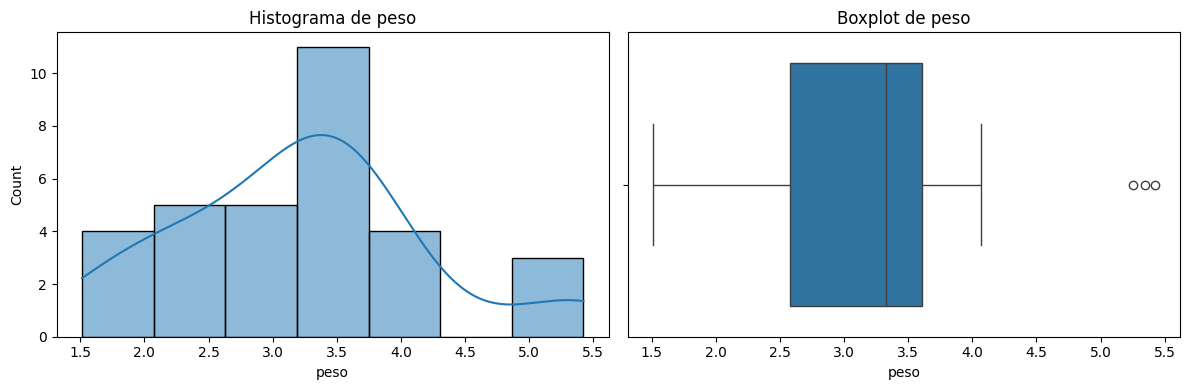

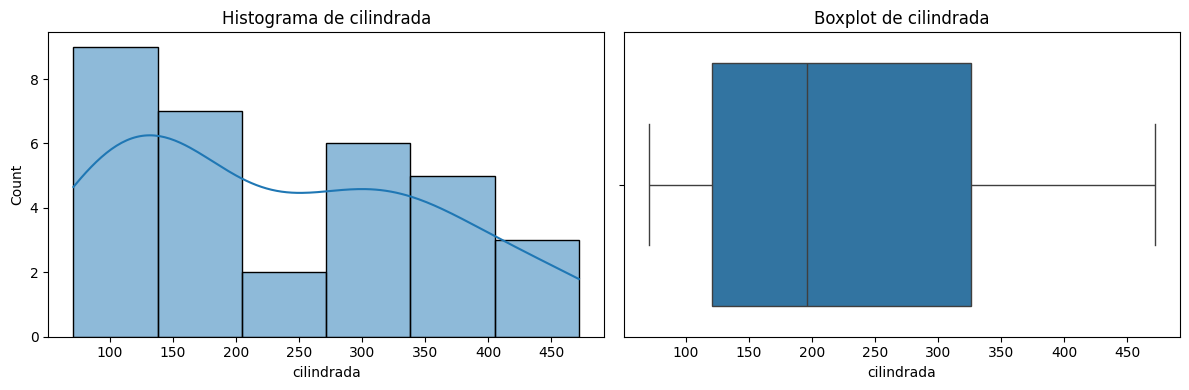

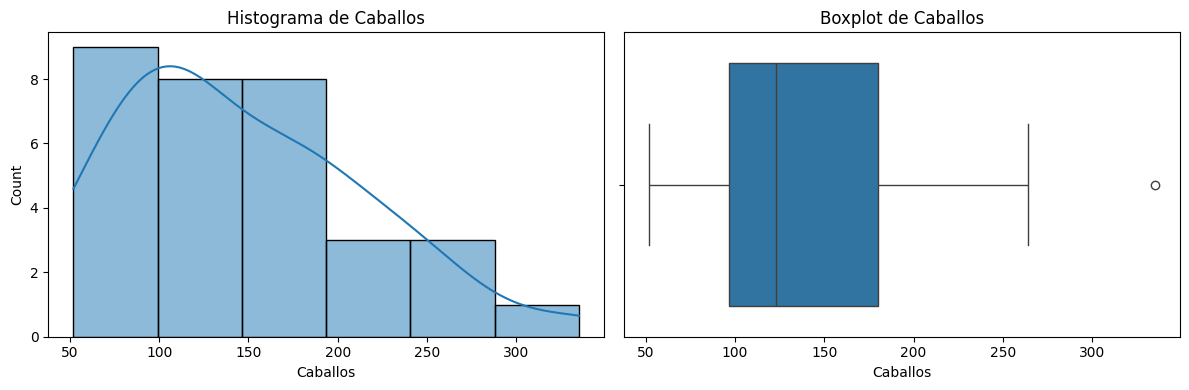

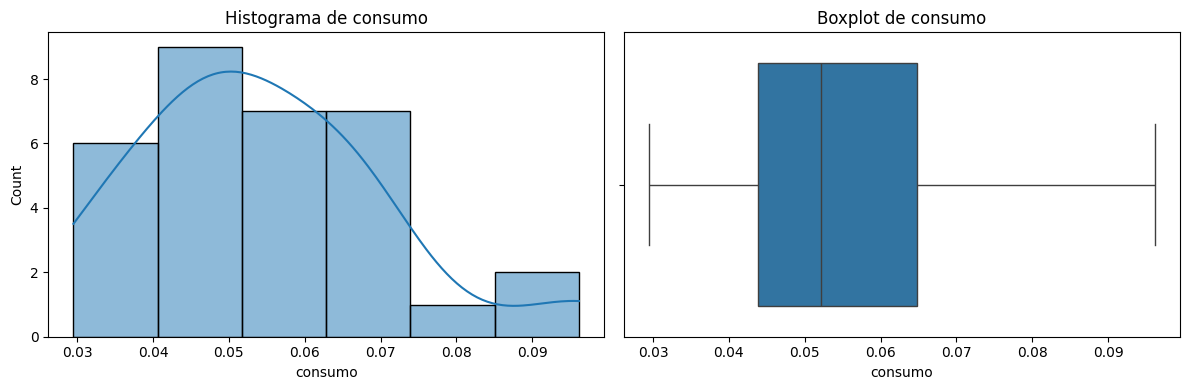

In [ ]:
explorar_cuantitativas(df)

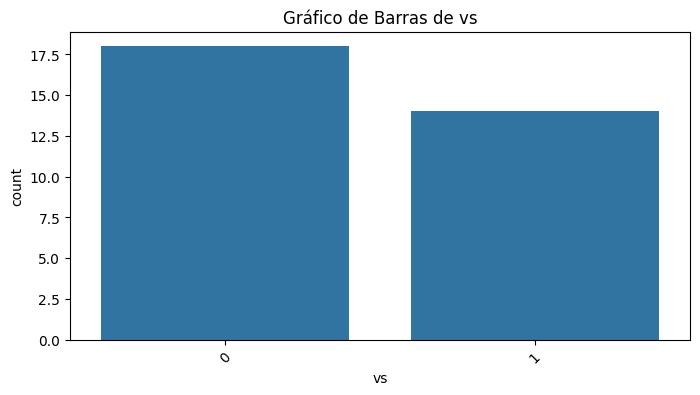

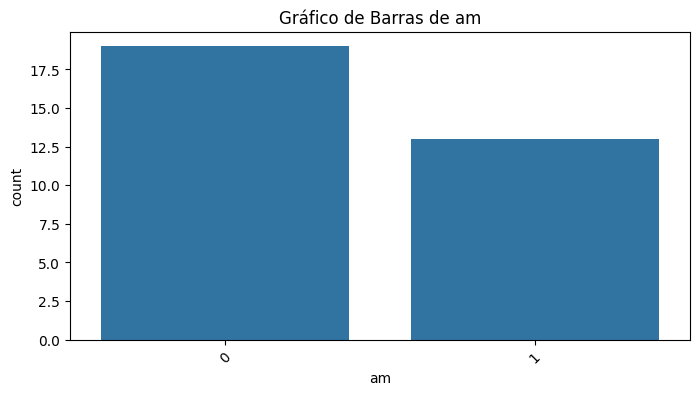

In [ ]:
explorar_cualitativas(df)

## Matrixplot mtcars

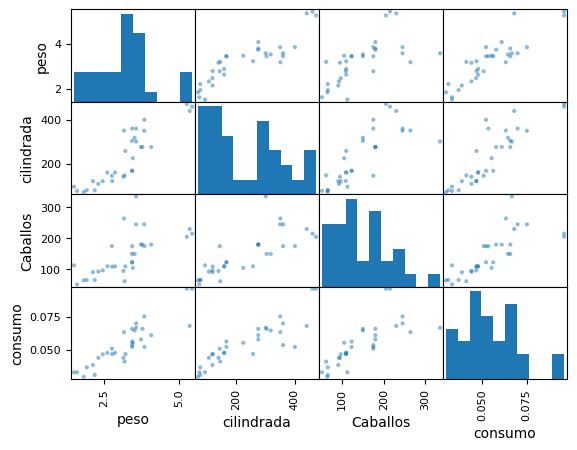

In [ ]:
# Descripción
pd.plotting.scatter_matrix(df)
plt.show()

## Relación con el consumo

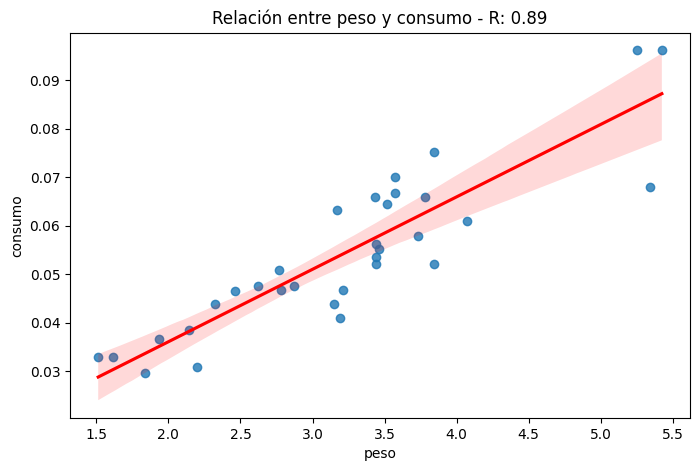

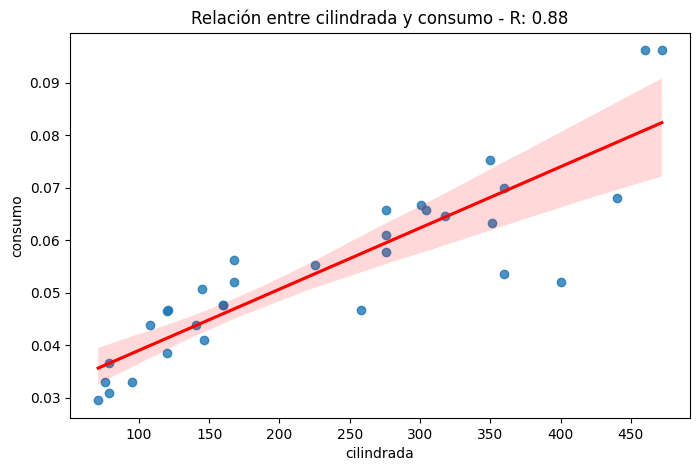

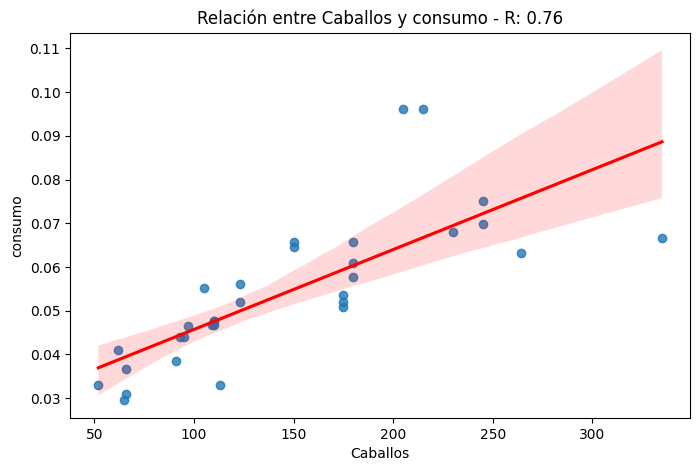

In [ ]:
explorar_relacion_con_salida(df, "consumo")

<ipython-input-64-ec32f4383150>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x=col, y=variable_cuantitativa, data=df, ci="sd", ax=axs[0])


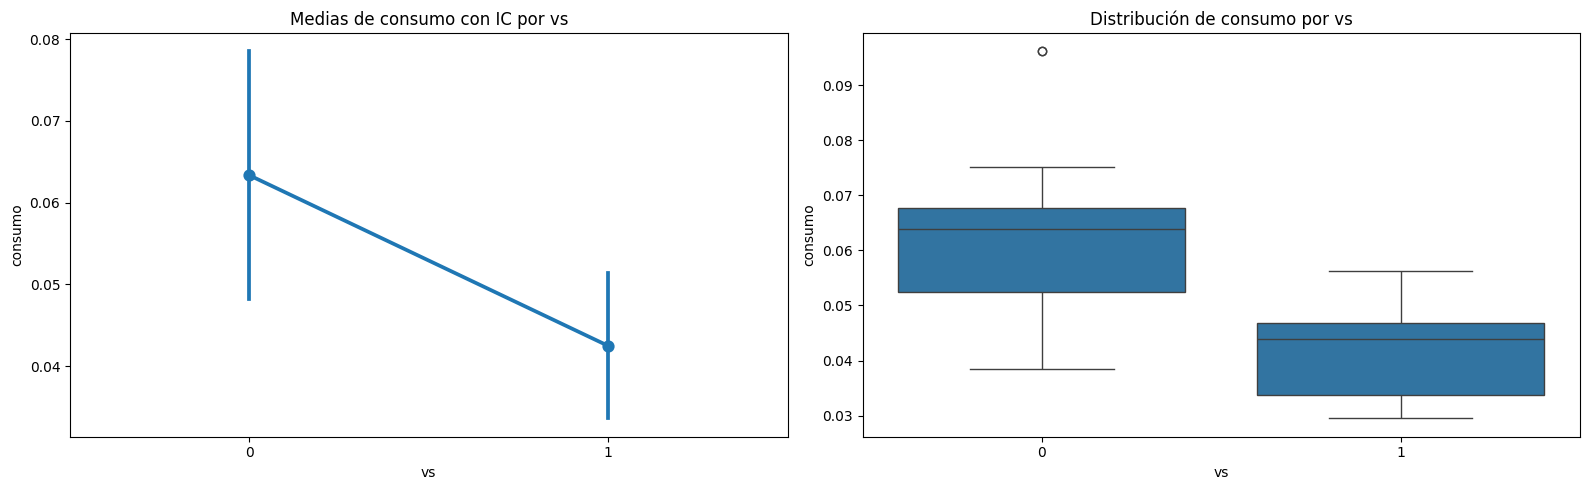

<ipython-input-64-ec32f4383150>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.pointplot(x=col, y=variable_cuantitativa, data=df, ci="sd", ax=axs[0])


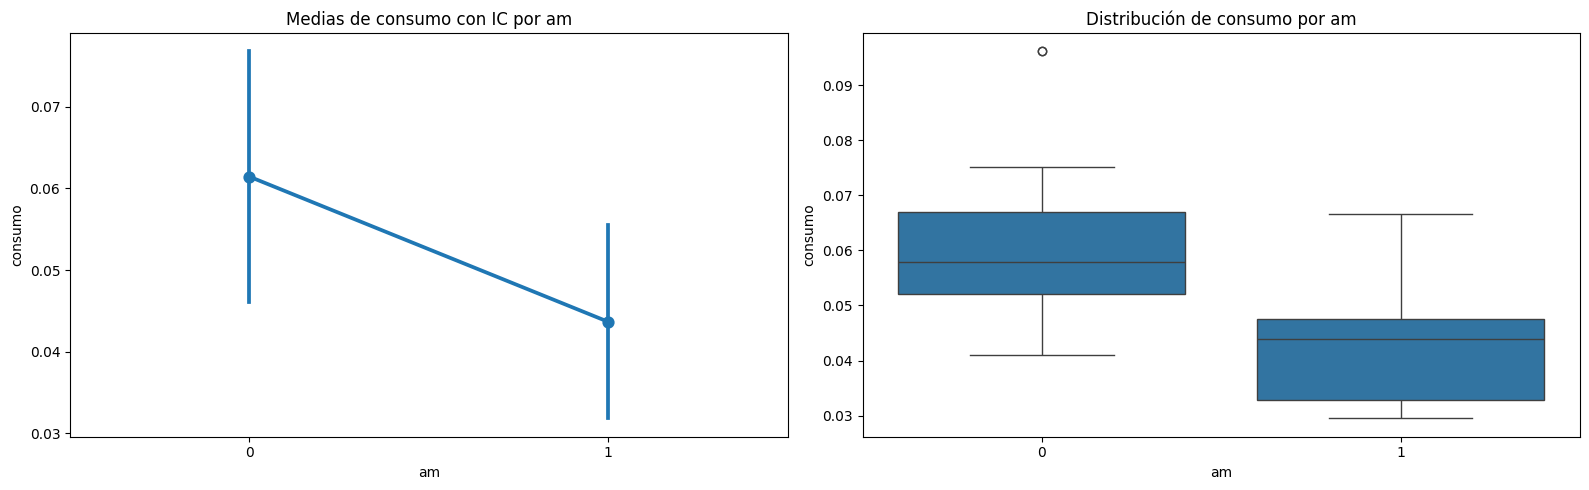

In [ ]:
explorar_relacion_cuantitativa_categorica(df, "consumo")

# GLM - enlaces de interés

- Tipos de GLM: https://en.wikipedia.org/wiki/Generalized_linear_model

- Stats models ejemplo de glm: https://www.statsmodels.org/dev/examples/index.html#generalized-linear-models

- Stats models familias y funciones de enlace disponible: https://www.statsmodels.org/dev/glm.html#families

# GLM - familia Gaussiana

## Modelo 1 - con la variable vs como categórica usando familia Gaussiana

In [ ]:
df.head()

,peso,cilindrada,Caballos,consumo,vs,am
rownames,,,,,,
Mazda RX4,2.620,160.0,110,0.047619,0,1
Mazda RX4 Wag,2.875,160.0,110,0.047619,0,1
Datsun 710,2.320,108.0,93,0.043860,1,1
Hornet 4 Drive,3.215,258.0,110,0.046729,1,0
Hornet Sportabout,3.440,360.0,175,0.053476,0,0


In [ ]:
# modelo1 - con vs
modelo = sm.formula.glm(formula = "consumo ~ peso + Caballos + vs", data = df, family = sm.families.Gaussian())
print(modelo.fit().summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                consumo   No. Observations:                   32
Model:                            GLM   Df Residuals:                       28
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                      4.4908e-05
Method:                          IRLS   Log-Likelihood:                 116.90
Date:                Mon, 11 Mar 2024   Deviance:                    0.0012574
Time:                        15:46:23   Pearson chi2:                  0.00126
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9929
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0096      0.006      1.524      0.1

consumo = 0.0096 - 0.0024·vs.1 + 0.0113·peso + 6.361e-05·Caballos + error

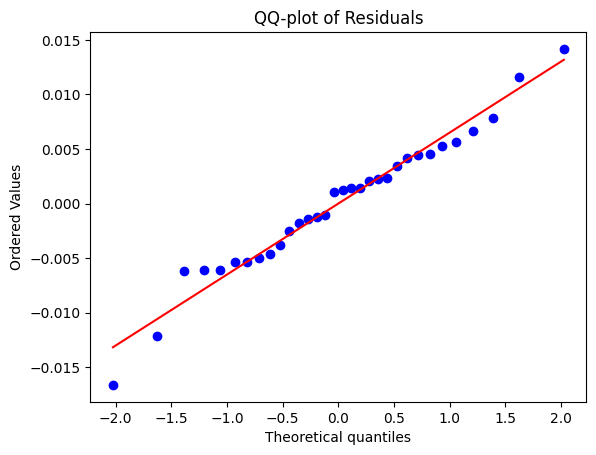

In [ ]:
# Interpretar los residuos del modelo:
# Residuals review
#*******************************************************************************
# · 2D scatter to check no autocorrelation
# · Check if they are normally distributed
# · Check collinearity with VIF coefficient
# 2D scatter of residuals

result = modelo.fit()
residuals = result.resid_anscombe_unscaled
df_residuals = pd.DataFrame({"Residuals":residuals})

# 2D scatter
fig = px.scatter(df_residuals, x=df_residuals.index, y='Residuals', title='Residuals Linear Regression')
fig.show()

# Frequency histogram with plotly
fig = px.histogram(df_residuals, x='Residuals', title='Frequency Histogram of Residuals')
fig.show()

# Boxplot
fig = px.box(df_residuals, y='Residuals', title='Boxplot of Residuals')
fig.show()

# QQplot
import scipy.stats as stats
import pylab

# Generating the qqplot
stats.probplot(df_residuals['Residuals'], dist="norm", plot=pylab)
pylab.title("QQ-plot of Residuals")
pylab.show()

In [ ]:
# Normal distribution test
stats.shapiro(df_residuals['Residuals'])

ShapiroResult(statistic=0.9782750606536865, pvalue=0.7480883002281189)

## Modelo 2 - con la variable am como categórica usando familia Gaussiana

In [ ]:
# modelo2 con am
modelo = sm.formula.glm(formula = "consumo ~ peso + Caballos + am", data = df, family = sm.families.Gaussian())
print(modelo.fit().summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                consumo   No. Observations:                   32
Model:                            GLM   Df Residuals:                       28
Model Family:                Gaussian   Df Model:                            3
Link Function:               Identity   Scale:                      4.5603e-05
Method:                          IRLS   Log-Likelihood:                 116.66
Date:                Mon, 11 Mar 2024   Deviance:                    0.0012769
Time:                        15:48:08   Pearson chi2:                  0.00128
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9923
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0052      0.007      0.734      0.4

## Modelo 3 - con dos variables categóricas usando familia Gaussiana

In [ ]:
# modelo3 con am y vs
modelo = sm.formula.glm(formula = "consumo ~ peso + Caballos + am +vs", data = df, family = sm.families.Gaussian())
print(modelo.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                consumo   No. Observations:                   32
Model:                            GLM   Df Residuals:                       27
Model Family:                Gaussian   Df Model:                            4
Link Function:               Identity   Scale:                      4.6561e-05
Method:                          IRLS   Log-Likelihood:                 116.91
Date:                Mon, 11 Mar 2024   Deviance:                    0.0012571
Time:                        15:50:33   Pearson chi2:                  0.00126
No. Iterations:                     3   Pseudo R-squ. (CS):             0.9916
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0090      0.009      0.975      0.3

## Comparación de los tres modelos con BIC

In [ ]:
# BIC del modelo 1
modelo_1 = sm.formula.glm(formula = "consumo ~ peso + Caballos + vs", data = df, family = sm.families.Gaussian()).fit()
print("BIC del modelo 1 = "+str(modelo_1.bic))

# BIC del modelo 2
modelo_2 = sm.formula.glm(formula = "consumo ~ peso + Caballos + am", data = df, family = sm.families.Gaussian()).fit()
print("BIC del modelo 2 = "+str(modelo_2.bic))

# BIC del modelo 3
modelo_3 = sm.formula.glm(formula = "consumo ~ peso + Caballos + vs + am", data = df, family = sm.families.Gaussian()).fit()
print("BIC del modelo 3 = "+str(modelo_3.bic))

# BIC del modelo 4
modelo_4 = sm.formula.glm(formula = "consumo ~ peso + Caballos", data = df, family = sm.families.Gaussian()).fit()
print("BIC del modelo 4 = "+str(modelo_4.bic))

BIC del modelo 1 = -97.0393478531826
BIC del modelo 2 = -97.03932840232683
BIC del modelo 3 = -93.57361224154134
BIC del modelo 4 = -100.50506245546559


/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning:

The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning:

The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling 

In [ ]:
modelo_4.bic

/usr/local/lib/python3.10/dist-packages/statsmodels/genmod/generalized_linear_model.py:1923: FutureWarning:

The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.



-100.50506245546559

## Seleccion de variables automática con el STEPWISE SOLO VÁLIDA PARA VARIABLES CUANTITATIVAS

In [ ]:
df.head()

,peso,cilindrada,Caballos,consumo,vs,am
rownames,,,,,,
Mazda RX4,2.620,160.0,110,0.047619,0,1
Mazda RX4 Wag,2.875,160.0,110,0.047619,0,1
Datsun 710,2.320,108.0,93,0.043860,1,1
Hornet 4 Drive,3.215,258.0,110,0.046729,1,0
Hornet Sportabout,3.440,360.0,175,0.053476,0,0


In [ ]:
df.columns

Index(['peso', 'cilindrada', 'Caballos', 'consumo', 'vs', 'am'], dtype='object')

In [ ]:
selected_variables = stepwise_selection_glm(df[['peso', 'cilindrada', 'Caballos', 'consumo']], 'consumo', sm.families.Gaussian(), verbose=True)
print("Selected variables:", selected_variables)

Adding peso
                 Generalized Linear Model Regression Results                  
Dep. Variable:                consumo   No. Observations:                   32
Model:                            GLM   Df Residuals:                       30
Model Family:                Gaussian   Df Model:                            1
Link Function:               Identity   Scale:                      0.00011649
Method:                          IRLS   Log-Likelihood:                 100.55
Date:                Mon, 11 Mar 2024   Deviance:                    0.0034948
Time:                        15:56:31   Pearson chi2:                  0.00349
No. Iterations:                     3   Pseudo R-squ. (CS):             0.7296
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0274      0.005      6.

# GLM - regresión de Poisson y Binomial negativa (variable respuesta de contaje)

## Lectura de datos simulados para el ejemplo

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#file_gd = "C:/Users/Jordi/Documents/PYTHON/005_ANALIZA_TUS_DATOS_V2/600_02-analiza-tus-datos-modelos-estadisticos/datos/poisson_sim.csv"
file_gd = "/content/drive/MyDrive/001 PRODUCTOS   SERVICIOS/03-ANALIZA TUS DATOS 2.0/015-ANALIZA TUS IN COMPANY/ANALIZA TUS DATOS Estadistica Avanzada y ML Toulouse/SESION 1 - MODELOS ESTADISTICOS/PYTHON PASO A PASO/datos/poisson_sim.csv"

data = pd.read_csv(file_gd,sep=",")
data.head()

,id,num_awards,prog,math
0,45,0,3,41
1,108,0,1,41
2,15,0,3,44
3,67,0,3,42
4,153,0,3,40


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   id          200 non-null    int64
 1   num_awards  200 non-null    int64
 2   prog        200 non-null    int64
 3   math        200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [ ]:
# Define the levels and labels for the "prog" column
levels = [1, 2, 3]
labels = ["General", "Academic", "Vocational"]

# Convert "prog" and "id" columns to factor variables
data["prog"] = pd.Categorical(data["prog"], categories=levels, ordered=True)
data["prog"] = data["prog"].cat.rename_categories(labels)
data["id"] = pd.Categorical(data["id"])
data.head()

,id,num_awards,prog,math
0,45,0,Vocational,41
1,108,0,General,41
2,15,0,Vocational,44
3,67,0,Vocational,42
4,153,0,Vocational,40


## Descripción de la variable respuesta

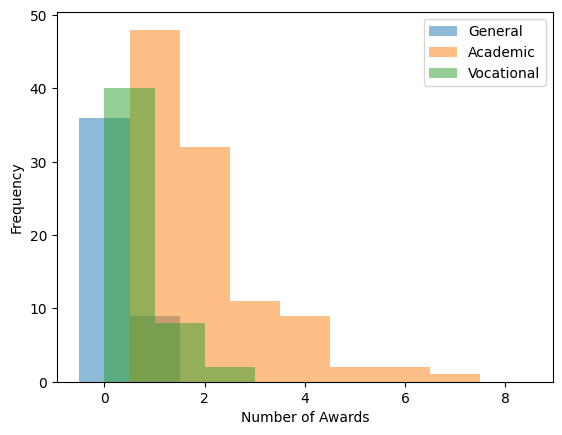

In [ ]:
# Filter the data by program type
general_program = data[data['prog'] == "General"]
academic_program = data[data['prog'] == "Academic"]
vocational_program = data[data['prog'] == "Vocational"]

# Set up the plot
fig, ax = plt.subplots()
ax.set_xlabel('Number of Awards')
ax.set_ylabel('Frequency')

# Plot the histograms
ax.hist(general_program['num_awards'], bins=range(0, 9), alpha=0.5, label='General', align='left')
ax.hist(academic_program['num_awards'], bins=range(0, 9), alpha=0.5, label='Academic', align='right')
ax.hist(vocational_program['num_awards'], bins=range(0, 9), alpha=0.5, label='Vocational')

# Add a legend
ax.legend(loc='best')

# Show the plot
plt.show()

## Regresión de Poisson

### Modelo de Poisson con stats models

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.sandwich_covariance import cov_cluster

# Cálculo Modelo Poisson

# Modelo Poisson
modelo1Poisson = smf.glm('num_awards ~ prog + math', family=sm.families.Poisson(), data=data).fit()

# Resultados del modelo Poisson
print(modelo1Poisson.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_awards   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -182.75
Date:                Mon, 11 Mar 2024   Deviance:                       189.45
Time:                        16:19:46   Pearson chi2:                     212.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.3881
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.2471      0

Num_Premios = exp(-5.2471 + 1.0839*prog_Academico + 0.3698·prog_Vocacional+0.0702·Nota_Matematicas)+error

### Calidad del modelo de Poisson

In [ ]:
# Bondad de ajuste del modelo:

from scipy.stats import chi2

res_deviance = modelo1Poisson.deviance
df_res = modelo1Poisson.df_resid
p = 1 - chi2.cdf(res_deviance, df_res)
print(pd.DataFrame({'res.deviance': res_deviance, 'df': df_res, 'p': p}, index=[0]))

   res.deviance   df         p
0     189.44962  196  0.618227


In [ ]:
# Test de sobredispersión:

# Calculate the Pearson chi-square statistic
pearson_chi_sq = modelo1Poisson.pearson_chi2

# Calculate the degrees of freedom
df = modelo1Poisson.df_resid

# Calculate the p-value of the Pearson chi-square test
p_value = 1 - chi2.cdf(pearson_chi_sq, df)

# Print the results
print("Pearson chi-square test:")
print(f"  Pearson chi-square statistic = {pearson_chi_sq}")
print(f"  Degrees of freedom = {df}")
print(f"  p-value = {p_value}")

# If the p-value is less than 0.05, it suggests that the model may be overdispersed,
# meaning that the variance of the response variable is greater than the mean,
# and the Poisson distribution may not be the best choice.
# You can try fitting a negative binomial model or quasi-Poisson model instead to account for the overdispersion.

Pearson chi-square test:
  Pearson chi-square statistic = 212.14373497920153
  Degrees of freedom = 196
  p-value = 0.20398603376789337


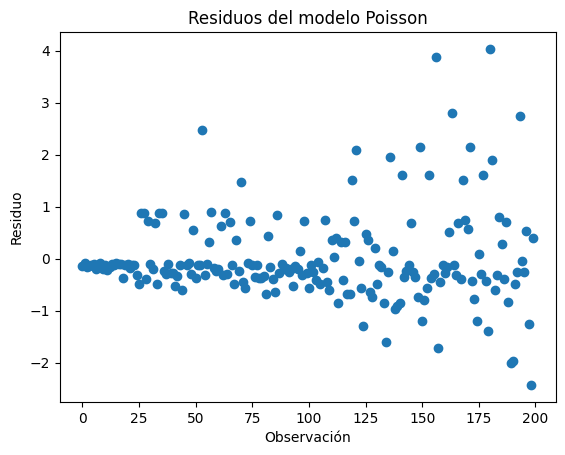

In [ ]:
# Plot residuos

import matplotlib.pyplot as plt
plt.plot(modelo1Poisson.resid_response, 'o')
plt.title('Residuos del modelo Poisson')
plt.xlabel('Observación')
plt.ylabel('Residuo')
plt.show()

### Predicción con el modelo de Poisson

In [ ]:
modelo1Poisson.predict()

array([0.13519097, 0.09339886, 0.16685841, 0.14501552, 0.12603202,
       0.10018631, 0.19199136, 0.12603202, 0.07712822, 0.19199136,
       0.12603202, 0.22369447, 0.16685841, 0.10211287, 0.12603202,
       0.08117233, 0.10746702, 0.10953359, 0.36552984, 0.11749357,
       0.10018631, 0.17898428, 0.12603202, 0.12603202, 0.31767953,
       0.48393834, 0.11527682, 0.13264033, 0.39209349, 0.27609315,
       0.10018631, 0.20594369, 0.31767953, 0.48393834, 0.12603202,
       0.11749357, 0.23696385, 0.2961573 , 0.10746702, 0.27609315,
       0.28695274, 0.51910693, 0.34076583, 0.11749357, 0.59729713,
       0.13519097, 0.11749357, 0.08117233, 0.29247078, 0.45115236,
       0.36552984, 0.12603202, 0.13264033, 0.51910693, 0.31767953,
       0.10746702, 0.68726468, 0.10018631, 0.17898428, 0.23249305,
       0.20594369, 0.36552984, 0.31767953, 0.12603202, 0.29247078,
       0.29247078, 0.12365418, 0.48393834, 0.64070369, 0.23249305,
       0.51910693, 0.45115236, 0.55683129, 0.09339886, 0.27265

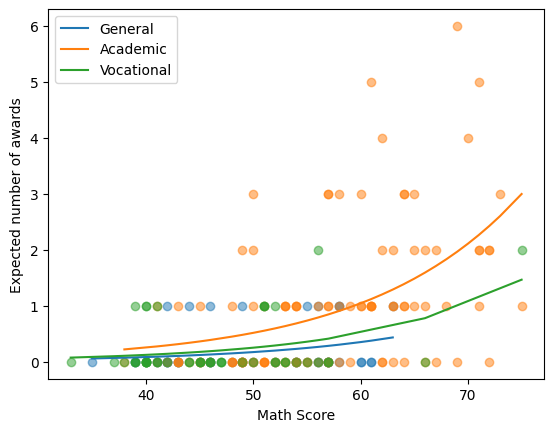

In [ ]:
# Plot de la respueta predicha del modelo y los valores observados:

# Calculate and store predicted values
data['phat'] = modelo1Poisson.predict()

# Order by program and then by math
dataSort = data.sort_values(by=['prog', 'math'])

# Create the plot
fig, ax = plt.subplots()

for prog, group in dataSort.groupby("prog"):
    ax.plot(group["math"], group["phat"], label=prog)
    ax.scatter(group["math"], group["num_awards"], alpha=0.5)

ax.set_xlabel("Math Score")
ax.set_ylabel("Expected number of awards")
ax.legend()

plt.show()

## Regresión Binomial Negativa

### Modelo de Binomial Negativa con stats models

In [ ]:
# Fit a negative binomial model

# Define the logarithmic link function
log_link = sm.families.links.log()

# Fit a negative binomial model with the logarithmic link function
modelo1PoissonNeg = smf.glm('num_awards ~ prog + math',
                            data=data,
                            family=sm.families.NegativeBinomial(link=log_link)).fit()

# Print the model summary
print(modelo1PoissonNeg.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:             num_awards   No. Observations:                  200
Model:                            GLM   Df Residuals:                      196
Model Family:        NegativeBinomial   Df Model:                            3
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -187.98
Date:                Wed, 22 Feb 2023   Deviance:                       123.41
Time:                        10:44:58   Pearson chi2:                     139.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2555
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -5.3435      0

### Calidad del modelo de Binomial Negativa

In [ ]:
# Bondad de ajuste del modelo:

from scipy.stats import chi2

res_deviance = modelo1PoissonNeg.deviance
df_res = modelo1PoissonNeg.df_resid
p = 1 - chi2.cdf(res_deviance, df_res)
print(pd.DataFrame({'res.deviance': res_deviance, 'df': df_res, 'p': p}, index=[0]))

   res.deviance   df         p
0     123.41259  196  0.999988


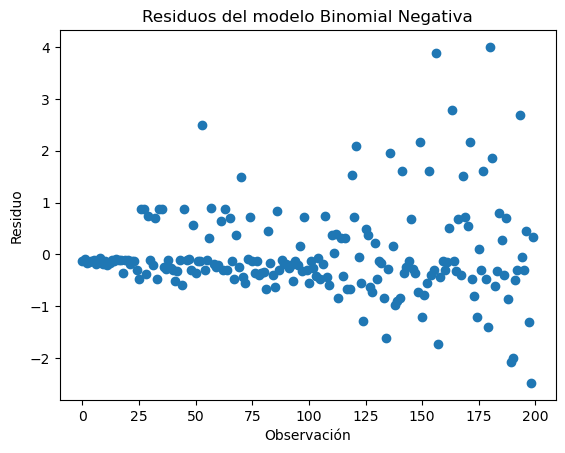

In [ ]:
# Plot residuos

import matplotlib.pyplot as plt
plt.plot(modelo1PoissonNeg.resid_response, 'o')
plt.title('Residuos del modelo Binomial Negativa')
plt.xlabel('Observación')
plt.ylabel('Residuo')
plt.show()

# GLM - regresión logística Binomial (variables respuesta categórica binaria)

## Lectura de datos de apnea del sueño

In [ ]:
#file_gd = "C:/Users/Jordi/Documents/PYTHON/005_ANALIZA_TUS_DATOS_V2/600_02-analiza-tus-datos-modelos-estadisticos/datos/datos_apnea.xlsx"
file_gd = "/content/drive/MyDrive/001 PRODUCTOS   SERVICIOS/03-ANALIZA TUS DATOS 2.0/015-ANALIZA TUS IN COMPANY/ANALIZA TUS DATOS Estadistica Avanzada y ML Toulouse/SESION 1 - MODELOS ESTADISTICOS/PYTHON PASO A PASO/datos/datos_apnea.xlsx"


data = pd.read_excel(file_gd)
data.head()

,idusar,codigohospital,iah,IAH30,edad,sexo,Menopausa,Epworth,Epworthcateg,somnATS,...,cin,icc,waistheightR,TAS_m,TAD_m,hipert,knowntreatedDM,dlp,cin_1y,epworth1y
0,1,bellvitge,99.6,1,48,0,0.0,17,1,2,...,144,0.979592,91.139241,160.0,100.0,1,1,1.0,146.532945,19
1,2,bellvitge,33.1,1,48,0,0.0,10,0,1,...,130,0.915493,85.526316,130.0,80.0,0,0,0.0,131.388030,8
2,3,bellvitge,114.6,1,51,1,NaN,3,0,1,...,152,0.955975,88.372093,150.0,90.0,1,1,1.0,151.582124,7
3,4,bellvitge,6.7,0,32,0,0.0,1,0,1,...,115,0.858209,70.552147,132.0,83.0,0,0,0.0,113.957091,3
4,5,bellvitge,47.4,1,45,0,0.0,2,0,1,...,126,0.961832,85.135135,166.0,100.0,0,0,0.0,123.314899,1


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   idusar          159 non-null    int64  
 1   codigohospital  159 non-null    object 
 2   iah             159 non-null    float64
 3   IAH30           159 non-null    int64  
 4   edad            159 non-null    int64  
 5   sexo            159 non-null    int64  
 6   Menopausa       114 non-null    float64
 7   Epworth         159 non-null    int64  
 8   Epworthcateg    159 non-null    int64  
 9   somnATS         159 non-null    int64  
 10  imc             159 non-null    float64
 11  p_cuello        159 non-null    float64
 12  cin             159 non-null    int64  
 13  icc             159 non-null    float64
 14  waistheightR    159 non-null    float64
 15  TAS_m           158 non-null    float64
 16  TAD_m           158 non-null    float64
 17  hipert          159 non-null    int

## Regresión logística binaria simple

### Modelo logístico con stats models

In [ ]:

# logistic regression using formula syntax
formula = 'IAH30 ~ TAS_m'
regresionLogisticaSimple = smf.logit(formula, data=data).fit()

# print summary
print(regresionLogisticaSimple.summary())



Optimization terminated successfully.
         Current function value: 0.621590
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  IAH30   No. Observations:                  158
Model:                          Logit   Df Residuals:                      156
Method:                           MLE   Df Model:                            1
Date:                Mon, 11 Mar 2024   Pseudo R-squ.:                 0.09948
Time:                        16:33:26   Log-Likelihood:                -98.211
converged:                       True   LL-Null:                       -109.06
Covariance Type:            nonrobust   LLR p-value:                 3.188e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.1623      1.478     -4.170      0.000      -9.059      -3.266
TAS_m          0.0468      0.

Probabilidad_Paciente_Grave = logit(-6.1623 + 0.0468*TAS_m)+ error

### Predicciones con nuevos datos

In [ ]:
# convert odd ratio to probability
newdata = pd.DataFrame({'TAS_m': [150,170, 185]})
probabilities = regresionLogisticaSimple.predict(newdata)
print(probabilities)

0    0.702593
1    0.857653
2    0.924011
dtype: float64


### Validación del modelo

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
m1 = regresionLogisticaSimple


# Classification error
prediccion = m1.predict(data)
y_pred = [1 if i > 0.5 else 0 for i in prediccion]
y_true = data['IAH30']
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
misClassError = (fp + fn) / (tp + tn + fp + fn)
misClassError

0.34591194968553457

In [ ]:
# Calcular la matriz de confusión:

# define column and row names

cm = confusion_matrix(y_true, y_pred)
cols = ['Predicted 0', 'Predicted 1']
rows = ['True 0', 'True 1']

# create dataframe
df_cm = pd.DataFrame(cm, columns=cols, index=rows)

df_cm

,Predicted 0,Predicted 1
True 0,45,28
True 1,27,59


In [ ]:
(27+28)/(45+28+27+59)

0.34591194968553457

In [ ]:
1-(27+28)/(45+28+27+59)

0.6540880503144655

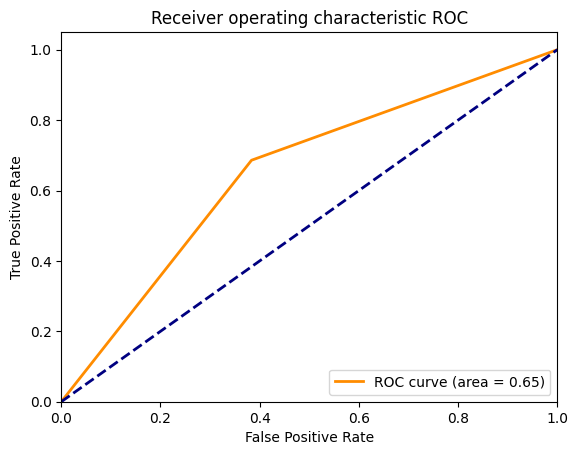

In [ ]:
# Pintar la curva ROC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assuming y_true and y_score are already defined
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Compute the classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
confusion = confusion_matrix(y_true, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"ROC AUC score: {roc_auc:.2f}")
print(f"Confusion matrix:\n{confusion}")


Accuracy: 0.65
Precision: 0.68
Recall: 0.69
F1-score: 0.68
ROC AUC score: 0.65
Confusion matrix:
[[45 28]
 [27 59]]


## Regresión logística binaria múltiple

### Modelo logístico binario múltiple con stats models

In [ ]:

# logistic regression using formula syntax
formula = 'IAH30 ~ TAS_m + sexo + edad'
m1 = smf.logit(formula, data=data).fit()

# print summary
print(m1.summary())



Optimization terminated successfully.
         Current function value: 0.598663
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  IAH30   No. Observations:                  158
Model:                          Logit   Df Residuals:                      154
Method:                           MLE   Df Model:                            3
Date:                Mon, 11 Mar 2024   Pseudo R-squ.:                  0.1327
Time:                        16:42:50   Log-Likelihood:                -94.589
converged:                       True   LL-Null:                       -109.06
Covariance Type:            nonrobust   LLR p-value:                 2.300e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.3248      1.605     -4.564      0.000     -10.470      -4.180
TAS_m          0.0403      0.

In [ ]:

# logistic regression using formula syntax
formula = 'IAH30 ~ TAS_m + edad'
m2 = smf.logit(formula, data=data).fit()

# print summary
print(m2.summary())


Optimization terminated successfully.
         Current function value: 0.607066
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                  IAH30   No. Observations:                  158
Model:                          Logit   Df Residuals:                      155
Method:                           MLE   Df Model:                            2
Date:                Mon, 11 Mar 2024   Pseudo R-squ.:                  0.1205
Time:                        16:42:59   Log-Likelihood:                -95.916
converged:                       True   LL-Null:                       -109.06
Covariance Type:            nonrobust   LLR p-value:                 1.956e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.1001      1.574     -4.512      0.000     -10.184      -4.016
TAS_m          0.0417      0.

### Predicciones con nuevos datos

In [ ]:
# convert odd ratio to probability
newdata = pd.DataFrame({'TAS_m': [170, 185], 'edad':[55,75]})
probabilities = m2.predict(newdata)
print(probabilities)

0    0.885970
1    0.968543
dtype: float64


### Validación del modelo

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
modelo = m2


# Classification error
prediccion = modelo.predict(data)
y_pred = [1 if i > 0.5 else 0 for i in prediccion]
y_true = data['IAH30']
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
misClassError = (fp + fn) / (tp + tn + fp + fn)
misClassError

0.3333333333333333

In [ ]:
# Calcular la matriz de confusión:

# define column and row names

cm = confusion_matrix(y_true, y_pred)
cols = ['Predicted 0', 'Predicted 1']
rows = ['True 0', 'True 1']

# create dataframe
df_cm = pd.DataFrame(cm, columns=cols, index=rows)

df_cm

,Predicted 0,Predicted 1
True 0,44,29
True 1,24,62


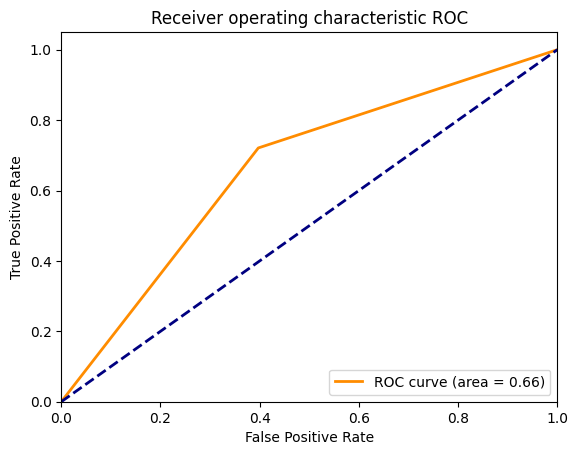

In [ ]:
# Pintar la curva ROC

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# assuming y_true and y_score are already defined
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic ROC')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Compute the classification metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_pred)
confusion = confusion_matrix(y_true, y_pred)

# Print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-score: {f1:.2f}")
print(f"ROC AUC score: {roc_auc:.2f}")
print(f"Confusion matrix:\n{confusion}")

Accuracy: 0.67
Precision: 0.68
Recall: 0.72
F1-score: 0.70
ROC AUC score: 0.66
Confusion matrix:
[[44 29]
 [24 62]]
